# Kaggle - Disaster Twitter - NLP Classification
Date:  2021-07-27
Source: https://www.kaggle.com/nikosraftogiannis/predicting-disaster-with-neural-networks-lstm#Make-some-analysis-on-validation-predictions
Model: 
- tensorflow.keras.lstm

Features:
- text
- word embedding

Libraries:
- tensorflow.keras
- spaCy
- tf.keras.layers.experimental.preprocessing.TextVectorization

Takeaways:
- this is and extremely concise, and well done notebook by nikosraftoginnis
- word embedding using spaCy en_core_web_lg pre-trained package
- the word vector is stored in a embedding_matrix with shape (22699, 300)
- used early stopping with optimizer NAdam 
- F1_Score class 
- tensorflow.keras callbacks



In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import tensorflow as tf

In [7]:
ds_train=pd.read_csv('train.csv' )
ds_test=pd.read_csv('test.csv' )

In [8]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [9]:
sequence_length_train = ds_train['text'].map(lambda x: len(x)).max()
sequence_length_test=ds_test['text'].map(lambda x: len(x)).max()
print (f'sequence_length_train: {sequence_length_train}')
print (f'sequence_length_test: {sequence_length_test}')

sequence_length_train: 157
sequence_length_test: 151


## Build Models

### build embedding matrix

In [10]:
vectorization_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    standardize = 'lower_and_strip_punctuation',
    output_mode='int'
)
vectorization_layer.adapt(np.array(ds_train.text))

In [11]:
nlp = spacy.load('en_core_web_lg')

In [12]:
embedding_dim = len(nlp('and').vector)

In [13]:
vector_vocabulary = vectorization_layer.get_vocabulary()
vocab_size = len(vector_vocabulary)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
embedding_matrix.shape

(22699, 300)

In [14]:
%%time
for i, word in enumerate(vector_vocabulary):
    embedding_matrix[i] = nlp(word).vector

Wall time: 3min 1s


### create model

In [15]:
model = tf.keras.Sequential([
    vectorization_layer,
    tf.keras.layers.Embedding(
        vocab_size,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [16]:
class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.metrics.Precision(thresholds=0.5)
        self.recall_fn = tf.metrics.Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

In [17]:
%%time
opt = tf.keras.optimizers.Nadam(0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', F1_Score()])

Wall time: 32 ms


In [18]:
X,y=np.array(ds_train['text']), np.array(ds_train['target'])
X.shape, y.shape

((7613,), (7613,))

### Fit model

In [19]:
%%time
history = model.fit(
    X,y,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True)
    ]    
)

Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.7869 - f1_score: 0.7266

C:\Users\sherry.gow\anaconda3\lib\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric F1_Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


54/54 [==============================] - 18s 226ms/step - loss: 0.4683 - accuracy: 0.7869 - f1_score: 0.7266 - val_loss: 0.4490 - val_accuracy: 0.8031 - val_f1_score: 0.7604
Epoch 2/100
54/54 [==============================] - 11s 204ms/step - loss: 0.2520 - accuracy: 0.9000 - f1_score: 0.8770 - val_loss: 0.5152 - val_accuracy: 0.7848 - val_f1_score: 0.7644
Epoch 3/100
54/54 [==============================] - 11s 209ms/step - loss: 0.0700 - accuracy: 0.9766 - f1_score: 0.9724 - val_loss: 0.6418 - val_accuracy: 0.7428 - val_f1_score: 0.7344ccu
Epoch 4/100
54/54 [==============================] - 11s 206ms/step - loss: 0.0278 - accuracy: 0.9893 - f1_score: 0.9875 - val_loss: 0.7939 - val_accuracy: 0.7415 - val_f1_score: 0.7312
Epoch 5/100
54/54 [==============================] - 11s 209ms/step - loss: 0.0154 - accuracy: 0.9943 - f1_score: 0.9933 - val_loss: 0.9344 - val_accuracy: 0.7441 - val_f1_score: 0.7361
Epoch 6/100
54/54 [==============================] - 11s 210ms/step - loss: 0.0

### plots

#### loss

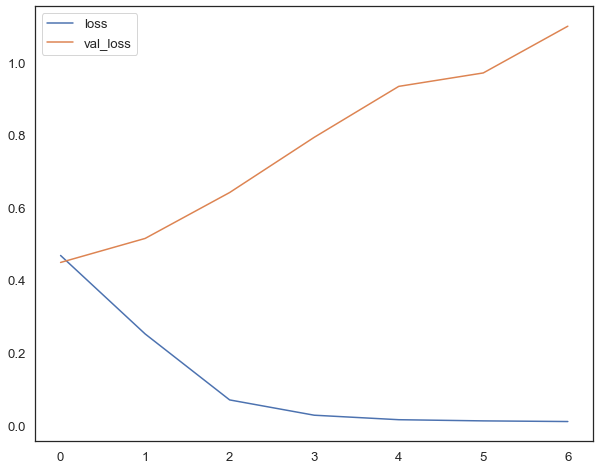

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

#### accuracy

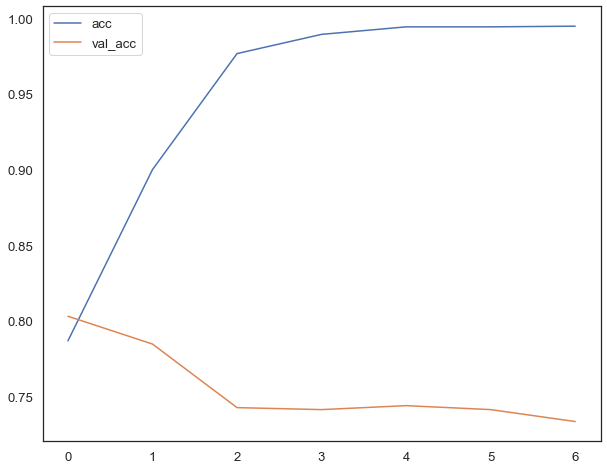

In [21]:
# Plotting accuracies
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

#### F1 Score

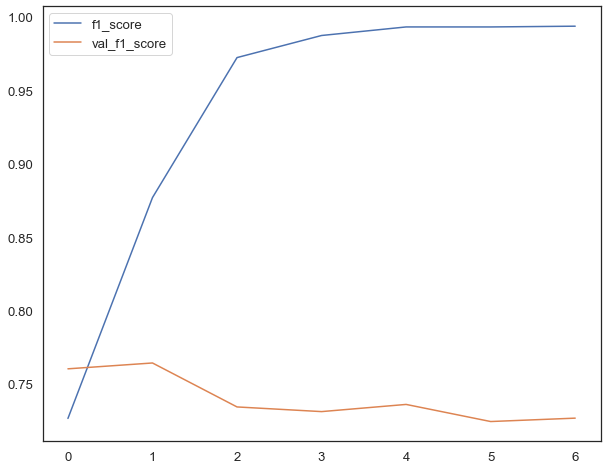

In [22]:
plt.plot(history.history['f1_score'], label='f1_score')
plt.plot(history.history['val_f1_score'], label='val_f1_score')
plt.legend()
plt.show()

## Making Prediction

In [23]:
prediction_scores = model.predict(np.array(ds_test.text))
prediction_classes = prediction_scores > 0.5 

In [24]:
submission = pd.DataFrame({'id': ds_test['id'], 'target': prediction_classes.flatten().astype(int)})
submission.to_csv('submission_niko_lstm.csv', index=False)